In [ ]:
import torch
import pandas as pd

# Load the dataset
df = pd.read_csv('data/movies_2015_2023_preprocessed_genre.csv')
df.head()

In [ ]:
value_tuples = []
for row in df.iterrows():
    values = row[1]
    value_tuples.append((values['language'], values['cleaned_overview']))

print(f'Total number of value tuples: {len(value_tuples)}')
print(f'First tuple: {value_tuples[0]}')
print(f'Last tuple: {value_tuples[-1]}')


In [ ]:
from sklearn.model_selection import train_test_split

train_value_tuples, test_value_tuples = train_test_split(value_tuples, test_size=0.3, shuffle=True, random_state=0)

print(f'Training set size: {len(train_value_tuples)}')
print(f'Testing set size: {len(test_value_tuples)}')

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')


In [ ]:
import re
from collections import Counter

# Custom tokenizer using regex
def custom_tokenizer(text):
    if isinstance(text, float):
        return []  # Return an empty list if the text is invalid
    text = text.lower()
    tokens = re.findall(r'\b\w+\b', text)
    return tokens

# Function to build the vocabulary and include the <unk> token
def build_vocab_from_tokens(data_iter):
    vocab_counter = Counter()
    
    # First, count tokens from the dataset
    for _, text in data_iter:
        tokens = custom_tokenizer(text)
        vocab_counter.update(tokens)
    
    # Create the vocabulary dictionary
    vocab = {token: idx for idx, token in enumerate(vocab_counter, start=1)}  # Start index from 1
    
    # Add the <unk> token at index 0
    vocab['<unk>'] = 0
    return vocab

# Build the vocabulary from the training data
vocab = build_vocab_from_tokens(train_value_tuples)

# Text pipeline using the custom tokenizer and vocabulary
text_pipeline = lambda x: [vocab[token] if token in vocab else vocab['<unk>'] for token in custom_tokenizer(x)]

# Example usage with a sample text
example_text = "This is a sample text."
print(f"Tokenized text: {custom_tokenizer(example_text)}")
print(f"Text as indices: {text_pipeline(example_text)}")


In [ ]:
# Step 1: Create a mapping from language labels to integers
language_mapping = {language: idx for idx, language in enumerate(set([label for label, _ in train_value_tuples]))}

# Step 2: Update the label_pipeline to map language strings to integers
label_pipeline = lambda x: language_mapping[x] if x in language_mapping else language_mapping['<unk>']

# Example: Print the mapping
print(f"Language to integer mapping: {language_mapping}")

# Example of how the label_pipeline would work
example_label = 'Spanisch'
print(f"Mapped label: {label_pipeline(example_label)}")


In [23]:
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (label, text) in batch:
        label_list.append(label_pipeline(label))
        processed_text = torch.tensor(text_pipeline(text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)


In [24]:
from torch import nn

class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

# Instantiate the model
num_class = len(set([label for (label, text) in train_value_tuples]))  # Adjusted for 'language'
vocab_size = len(vocab)
embed_size = 64
model = TextClassificationModel(vocab_size, embed_size, num_class).to(device)


In [25]:
import time

optimizer = torch.optim.SGD(model.parameters(), lr=5)
criterion = torch.nn.CrossEntropyLoss()

def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)

def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0
    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count


In [26]:
from torch.utils.data import Dataset, DataLoader

class MovieDataset(Dataset):
    def __init__(self, data, vocab, text_pipeline, label_pipeline):
        self.data = data
        self.vocab = vocab
        self.text_pipeline = text_pipeline
        self.label_pipeline = label_pipeline

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label, text = self.data[idx]
        processed_text = torch.tensor(self.text_pipeline(text), dtype=torch.int64)
        return self.label_pipeline(label), processed_text

def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (label, text) in batch:
        label_list.append(label)
        offsets.append(text.size(0))
        text_list.append(text)
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)

# Use your data to create Dataset
train_dataset = MovieDataset(train_value_tuples, vocab, text_pipeline, label_pipeline)
test_dataset = MovieDataset(test_value_tuples, vocab, text_pipeline, label_pipeline)

# DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True, collate_fn=collate_batch)


In [ ]:
for param in model.parameters():
    print(param)

In [ ]:
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    
    # Train for one epoch
    train_accuracy = train(train_dataloader)
    
    # Evaluate on validation set
    val_accuracy = evaluate(valid_dataloader)
    
    if total_accu is not None and total_accu > val_accuracy:
        scheduler.step()  # Adjust learning rate if accuracy decreases
    else:
        total_accu = val_accuracy
    
    print(f'| End of epoch {epoch} | Time: {time.time() - epoch_start_time:.2f}s | '
          f'Train Accuracy: {train_accuracy:.3f} | Valid Accuracy: {val_accuracy:.3f}')


In [ ]:
# Create test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)

# Helper function to combine batch results
def combine_result_batches(result):
    act_labels = []
    pred_labels = []
    labels_batches = result[0]
    pred_labels_batches = result[1]

    for batch in labels_batches:
        for label in batch.tolist():
            act_labels.append(label)
    
    for batch in pred_labels_batches:
        for label in batch.tolist():
            pred_labels.append(label)
    
    return (act_labels, pred_labels)

# Get predictions for the test set
result_batches = get_predictions(test_dataloader)
actual_labels, pred_labels = combine_result_batches(result_batches)

# Accuracy score
from sklearn.metrics import accuracy_score
score = accuracy_score(actual_labels, pred_labels)
print(f'Accuracy score: {score:.3f}')


In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'white'

# Confusion matrix
conf = confusion_matrix(actual_labels, pred_labels)
cm_display = metrics.ConfusionMatrixDisplay(conf, display_labels=['Language 1', 'Language 2', 'Language 3', ...])  # Replace with actual language names if necessary

cm_display.plot()
plt.show()


In [10]:
import torch
import pandas as pd
from torch import nn
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import re
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('data/movies_2015_2023_preprocessed_genre.csv')

# Prepare data tuples (language, cleaned overview)
value_tuples = [(row['language'], row['cleaned_overview']) for _, row in df.iterrows()]
print(f'Total number of value tuples: {len(value_tuples)}')
print(f'First tuple: {value_tuples[0]}')
print(f'Last tuple: {value_tuples[-1]}')

# Train/test split
train_value_tuples, test_value_tuples = train_test_split(value_tuples, test_size=0.3, shuffle=True, random_state=0)
print(f'Training set size: {len(train_value_tuples)}')
print(f'Testing set size: {len(test_value_tuples)}')

# Custom tokenizer using regex
def custom_tokenizer(text):
    if isinstance(text, float):  # Handle NaN values
        return []
    text = text.lower()
    tokens = re.findall(r'\b\w+\b', text)
    return tokens

# Build vocabulary
def build_vocab_from_tokens(data_iter):
    vocab_counter = Counter()
    for _, text in data_iter:
        tokens = custom_tokenizer(text)
        vocab_counter.update(tokens)
    
    vocab = {token: idx for idx, token in enumerate(vocab_counter, start=1)}  # Start index from 1
    vocab['<unk>'] = 0  # Unknown token
    return vocab

# Build vocabulary from the training data
vocab = build_vocab_from_tokens(train_value_tuples)

# Text pipeline to convert text into token indices
text_pipeline = lambda x: [vocab[token] if token in vocab else vocab['<unk>'] for token in custom_tokenizer(x)]

# Step 1: Create a mapping from language labels to integers, include '<unk>' for unknown labels
language_mapping = {language: idx for idx, language in enumerate(set([label for label, _ in train_value_tuples]))}
language_mapping['<unk>'] = len(language_mapping)  # Adding an unknown label placeholder

# Step 2: Update the label_pipeline to map language strings to integers
label_pipeline = lambda x: language_mapping.get(x, language_mapping['<unk>'])

# Example: Print the mapping to verify
print(f"Language to integer mapping: {language_mapping}")

# Create custom dataset class
class MovieDataset(Dataset):
    def __init__(self, data, vocab, text_pipeline, label_pipeline):
        self.data = data
        self.vocab = vocab
        self.text_pipeline = text_pipeline
        self.label_pipeline = label_pipeline

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label, text = self.data[idx]
        processed_text = torch.tensor(self.text_pipeline(text), dtype=torch.int64)
        return self.label_pipeline(label), processed_text

# Collate function for batching
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (label, text) in batch:
        label_list.append(label)
        offsets.append(text.size(0))
        text_list.append(text)
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)

# Model definition
class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

# Hyperparameters and device setup
EPOCHS = 10
LR = 5
BATCH_SIZE = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate model
num_class = len(language_mapping)
vocab_size = len(vocab)
embed_size = 64
model = TextClassificationModel(vocab_size, embed_size, num_class).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

# Dataset and DataLoader
train_dataset = MovieDataset(train_value_tuples, vocab, text_pipeline, label_pipeline)
test_dataset = MovieDataset(test_value_tuples, vocab, text_pipeline, label_pipeline)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)

# Training function
def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        loss.backward()
        # Remove gradient clipping temporarily
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
    return total_acc / total_count

# Evaluation function
def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0
    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count

# Training loop
total_accu = None
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    
    # Train for one epoch
    train_accuracy = train(train_dataloader)
    
    # Evaluate on validation set (using test_dataloader)
    val_accuracy = evaluate(test_dataloader)
    
    if total_accu is not None and total_accu > val_accuracy:
        scheduler.step()  # Adjust learning rate if accuracy decreases
    else:
        total_accu = val_accuracy
    
    print(f'| End of epoch {epoch} | Time: {time.time() - epoch_start_time:.2f}s | '
          f'Train Accuracy: {train_accuracy:.3f} | Valid Accuracy: {val_accuracy:.3f}')

# Test and evaluate the model
def get_predictions(dataloader):
    model.eval()
    labels, predicted_labels = [], []
    with torch.no_grad():
        for label, text, offsets in dataloader:
            predicted_label = model(text, offsets).argmax(1)
            labels.append(label)
            predicted_labels.append(predicted_label)
    return torch.cat(labels), torch.cat(predicted_labels)

# Combine test results
labels, predicted_labels = get_predictions(test_dataloader)

# Accuracy score
test_accuracy = accuracy_score(labels.cpu(), predicted_labels.cpu())
print(f'Test Accuracy: {test_accuracy:.3f}')



Total number of value tuples: 15500
First tuple: ('Indisch', 'upon realizing extent woman affected menses set create sanitary pad machine provide inexpensive sanitary pad woman rural india')
Last tuple: ('Italienisch', 'several european underground director turn ancient rule mankind inside shocking goresoaked interpretation god law bible world ending commandment dying')
Training set size: 10850
Testing set size: 4650
Language to integer mapping: {'Indisch': 0, 'Italienisch': 1, 'Französisch': 2, 'Amerikanisch': 3, 'Deutsch': 4, 'Spanisch': 5, '<unk>': 6}
| End of epoch 1 | Time: 0.42s | Train Accuracy: 0.311 | Valid Accuracy: 0.317
| End of epoch 2 | Time: 0.41s | Train Accuracy: 0.447 | Valid Accuracy: 0.422
| End of epoch 3 | Time: 0.53s | Train Accuracy: 0.590 | Valid Accuracy: 0.553
| End of epoch 4 | Time: 0.49s | Train Accuracy: 0.705 | Valid Accuracy: 0.601
| End of epoch 5 | Time: 0.44s | Train Accuracy: 0.798 | Valid Accuracy: 0.619
| End of epoch 6 | Time: 0.40s | Train Accur

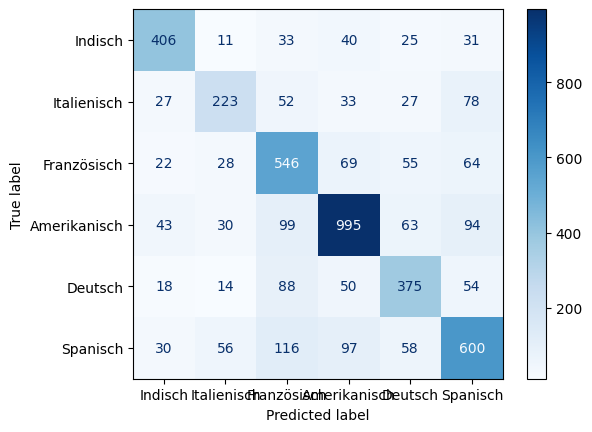

In [11]:
# Get predictions for the test set
def get_predictions(dataloader):
    model.eval()
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for idx, (labels, text, offsets) in enumerate(dataloader):
            predicted_output = model(text, offsets)
            predicted_labels = predicted_output.argmax(1)
            all_labels.extend(labels.tolist())
            all_predictions.extend(predicted_labels.tolist())
    
    return all_labels, all_predictions

# Get actual and predicted labels
actual_labels, pred_labels = get_predictions(test_dataloader)

# Generate confusion matrix and display
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(actual_labels, pred_labels)

# Remove '<unk>' if it's not present in the predictions
display_labels = list(language_mapping.keys())
if '<unk>' not in pred_labels:
    display_labels.remove('<unk>')

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=display_labels)
disp.plot(cmap='Blues')
plt.show()
